In [143]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [144]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask) #인코드에 왜 마스크
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        

In [145]:
class Generator(nn.Module):
    # linear + softmax
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [146]:
def clones(module, N):
    # make N identical layers
    # copy.deepcopy() = make immutable copies
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [147]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask): #왜 마스크
        # pass input and mask through each layer
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    


In [148]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()
        #무엇 
        self.a_2 = nn.Parameter(torch.ones(features)) 
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean)  / (std + self.eps) + self.b_2

In [149]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout) #dropout
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x))) #sublayer 무엇

In [150]:
# Encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) #이해 잘 안감
        return self.sublayer[1](x, self.feed_forward)

In [151]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [152]:
# Decode Layer
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        
        # multi head attention over the output of encoder stack
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
        
        
        
        
        
        
        

In [153]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    
    # np.triu = uppper triangular matrix 
    # k = 0 : main diagonal
    # k < 0 : below the mian diag
    # k > 0 : above the main diag
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 #numpy 객체 받기
    

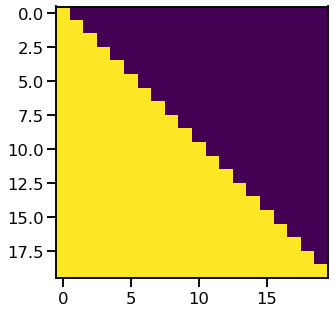

In [154]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])


In [155]:
# scaled dot product attention
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    
    # transpose(-2,-1) = 그냥 np.T랑 똑같은듯
    # 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [156]:
x = torch.ones(2,4)
x = x.transpose(1,0)
print(x)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


In [157]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout) #왜 해줌?
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3) Concat" using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
        

In [158]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [159]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [160]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len = 5000):
        super().__init__()
        # why need dropout
        self.dropout = nn.Dropout(p=dropout)
        
        # compute pe in log scale
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * 
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.
                                 size(1)], requires_grad=False)
        return self.dropout(x)

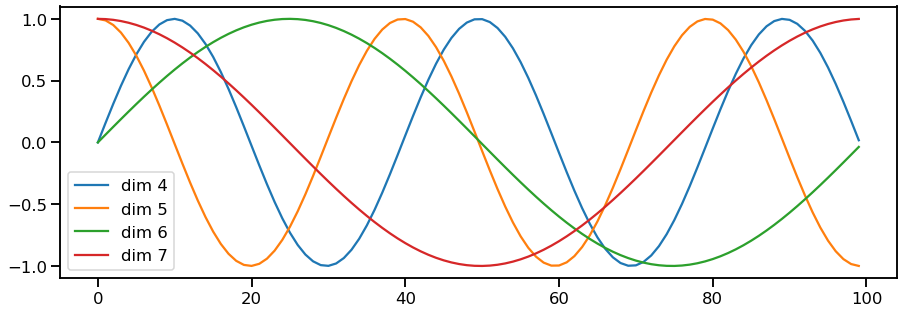

In [161]:
plt.figure(figsize=(15,5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" %p for p in [4,5,6,7]])

In [162]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    # construct model
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(\
                          Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
                          Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff),
                                              dropout), N),
                          nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
                          nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
                          Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [163]:
tmp_model = make_model(10, 10, 2)


In [164]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, :-1]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt  != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [165]:
def run_epoch(data_iter, model, loss_compute):
    
    # start traning and logging function
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch step: %d Loss: %f Tokens per Sec: %f" %(i, loss / batch.ntokens,
                                                                tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [166]:
global max_src_in_batch, max_tgt_in_batch

# create batches in a torchtext function 
# ensures batch size padded to the masimum batchsize
# not surpass threshold
def batch_size_fn(new, count, sofar):
    # keep augmenting batch and calculate total n of tokens + paddings
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [167]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor  = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
        
            
            
            

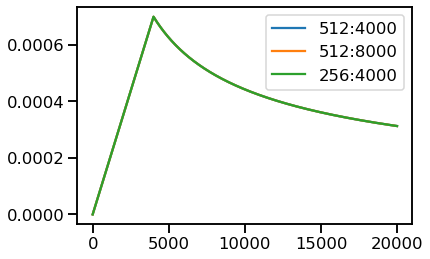

In [168]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [169]:
# label smoothing : useful technique for model generation
# as human annotates label, it 's highly possible to write wrong label
#  1) consider mislabeled daata
#  2) regularization
#  3) model generation
#  4) calibration
# distribution that has confidence of correct word and the rest of th
# smoothing mass distributed throughout the vocab
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super().__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
        
        
        
        
        

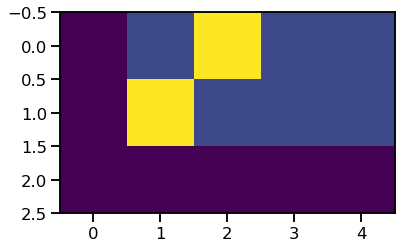

In [170]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, .2, .7, .1, 0],
                            [0, .2, .7, .1, 0],
                            [0, .2, .7, .1, 0],])

v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)
None

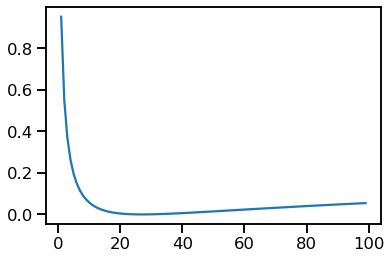

In [183]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    
    # in PyTorch >=0.5, index of 0-dim tensor is invalid.  data[0] --> data
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [184]:
# simple example
def data_gen(V, batch, nbatches):
    
    # random dataset for a src-tgt copy task
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [186]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y,  norm):
        x = self.generator(x)
        # contiguous() : follow memory storage rule of numpy
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data * norm

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400, 
                   torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                   SimpleLossCompute(model.generator, criterion, None)))

Epoch step: 1 Loss: 3.355361 Tokens per Sec: 996.529480
Epoch step: 1 Loss: 0.001155 Tokens per Sec: 889.815613
tensor(0.0008)
Epoch step: 1 Loss: 0.002346 Tokens per Sec: 924.708313
Epoch step: 1 Loss: 0.000004 Tokens per Sec: 1299.977173
tensor(3.3193e-06)
Epoch step: 1 Loss: 0.000019 Tokens per Sec: 814.818237
